In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np

# Prevents crashes when showing graphs
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
SIM_STEPS = 201

torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [52]:
# Pre-Determined train/test/val split
train_sims = np.load("../train_sims.npy")
train_sims = train_sims[train_sims < 750]
val_sims = np.load("../val_sims.npy")
val_sims = val_sims[val_sims < 750]
test_sims = np.load("../test_sims.npy")
test_sims = test_sims[test_sims < 750]

# Get porosity phi
def get_phi(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_phi.jpg", cv2.IMREAD_GRAYSCALE)

# Get pressure
def get_pres(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_P.jpg", cv2.IMREAD_GRAYSCALE)

# Get conductivity K
def get_k(sim,step):
    return cv2.imread(f"../Data200x200_withinfo/Image-{sim}-{step}_K.jpg", cv2.IMREAD_GRAYSCALE)

# Get all 3 as a 3-channel matrix
def get_all(sim,step):
    return np.array((get_k(sim,step), get_pres(sim,step), get_phi(sim,step)), dtype=np.float32)

In [53]:
# Darcy loss function
def darcy_loss(model, inp):
    # Takes in the k,pres,phi and outputs the prediction across the image.
    inp = inp.requires_grad_(True)
    out = model(inp)
    # out is in order K,P,phi, (conductivity, pressure, porosity)

    # Impose high pressure along the entire upper line by setting the pressure channelt to 200.
    out[:, 1:2, 0, :] = 200

    # If we assume the output is in order k,pres,phi
    # pres_grad is the gradient of the pressure along the y and x directions as a tuple
    pres_grad = torch.gradient(out[:, 1:2], dim=(-2,-1))

    # get velocity by multiplying the gradient by the conductivity
    y_grad = pres_grad[0] * out[:, 0:1]
    x_grad = pres_grad[1] * out[:, 0:1]

    # compute the divergence by the second derivative of the gradients and adding them together
    yy_grad = torch.gradient(y_grad, spacing=(1,),dim=(-2,))[0]
    xx_grad = torch.gradient(x_grad, spacing=(1,),dim=(-1,))[0]
    final = yy_grad + xx_grad

    # total divergence should be 0
    loss = (final**2).mean()

    return loss, out

In [54]:
# Building Blocks of the Unet

class TwoConv(nn.Module):
    # Basic block with 2 convolutional layers, each with a batch norm and relu
    
    def __init__(self, in_channels, out_channels, no_end_relu=False):
        super().__init__()
        
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        if no_end_relu:
            self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            )

    def forward(self, inp):
        return self.seq(inp)

# A single conv layer that will increase the height and width of the matrix by 2 each.
class SmallUp(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 2)

    def forward(self, inp):
        return F.relu(self.conv(inp))

# A single conv layer that will decrease the height and width of the matrix by 2 each.
class SmallDown(nn.Module):

    def __init__(self, channels):
        super().__init__()

        self.conv = nn.Conv2d(channels, channels, 3, 1, 0)

    def forward(self, inp):
        return F.relu(self.conv(inp))
    
# Applies two convolutional layers, then pools
class Downsample(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv = TwoConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, inp):

        return self.pool(self.conv(inp))

# Upsamples and concatenates the upsampled matrix with the "across" then performs convolution on the result
class Upsample(nn.Module):

    def __init__(self, in_channels, out_channels, tweak=None):
        super().__init__()
        # Upsamples by 2x
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1)
        self.tweak = tweak
        self.conv_after = TwoConv(in_channels, out_channels)

    def forward(self, below, across):
        # First upsample by 2x
        upsampled = self.up(below)
        # If tweak is active, apply it first
        if not self.tweak == None:
            upsampled = self.tweak(upsampled)
        # Concatenate with the same size on the downswing of the unet
        concat = torch.concat((upsampled, across), dim=-3)
        # Convolute them together
        return self.conv_after(concat)
    
# Define the actual model used
class SmallUnet(nn.Module):
    
    def __init__(self):
        super().__init__()

        # Input is Nx3x200x200
        self.c1 = TwoConv(3, 8)
        self.d1 = Downsample(8,16) # 16x100x100
        self.d2 = Downsample(16,32) # 32x50x50
        self.su = nn.Sequential(
            SmallUp(32),
            SmallUp(32),
            SmallUp(32)
        ) # 3x56x56
        self.d3 = Downsample(32,64) # 64x28x28
        self.d4 = Downsample(64,128) # 128x14x14
        self.d5 = Downsample(128, 256) # 256x7x7

        # Now back up
        self.u1 = Upsample(256, 128) # 128x14x14
        self.u2 = Upsample(128, 64) # 64x28x28
        self.u3 = Upsample(64, 32, tweak=nn.Sequential(
            SmallDown(32),
            SmallDown(32),
            SmallDown(32)
        ))  # 32x50x50
        self.u4 = Upsample(32,16) # 16x100x100
        self.u5 = Upsample(16,8) # 8x200x200
        self.final = TwoConv(8, 3, no_end_relu=True)

    def forward(self, input):
        # Start with convolution, expand 3 channels to 8.
        # Then downsample 5 times, saving the result
        top = self.c1(input)
        x1 = self.d1(top)
        x2 = self.d2(x1)
        x3 = self.d3(self.su(x2)) # Here we upsample slightly so that we can downsample with less border artifacts
        x4 = self.d4(x3)
        x5 = self.d5(x4)
        # Now that we're at 256x7x7, we upsample from here.
        # At each layer with concatenate with the xi that is the same size as the up after upsampling.
        up = self.u1(x5, x4)
        up = self.u2(up, x3)
        up = self.u3(up, x2) # Again, a small downsample here to get back on the proper resolution
        up = self.u4(up, x1)
        up = self.u5(up, top)
        # One last convolution on the result to return to 3 channels from 8, leaving us with the proper 3x200x200
        return self.final(up)

In [55]:
class MaskedDataset(torch.utils.data.Dataset):

    def __init__(self,
                 sims,
                 unmask_size=20,
                 points = None,
                 block_size = 50,
                 reveal_strategy = "block",
                 n_points = 200,
                 radius = 2,
                 steps = None,
                 H=200,
                 W=200,
                 channels="all",
                 mixed=False,
                 types=None,
                 noise=5,
                 return_mask=False,                 # allows visualiztion of mask
                 reveal_dim=[[(0, 1)], [(0, 1)]],   # x,y range for disks to exist
                 jitter_std=0.0,                    # % each disk drifts from deterministic position
                 deterministic_mask=True,            # if True, mask is deterministic and noise is 0
                 future_delta=0
                 ):
        
        self.sims = sims
        self.points = points
        self.steps = steps
        self.size = unmask_size
        self.reveal_strategy = reveal_strategy
        self.block_size = block_size
        self.n_points = n_points
        self.radius = radius
        self.H, self.W = H, W
        self.channels = channels
        self.mixed = mixed
        self.types = types
        self.noise = noise
        self.return_mask = return_mask
        self.reveal_dim = reveal_dim
        self.jitter_std = jitter_std
        self.deterministic_mask = deterministic_mask
        self.future_delta = future_delta

    def _chan_idx(self):
        if self.channels == "all":
            return [0,1,2]
        elif self.channels == "K":
            return [0]
        elif self.channels == "P":
            return [1]
        elif self.channels == "phi":
            return [2]
        else:
            raise ValueError("channels must be 'all', 'K', 'P', or 'phi'")

    
    

    def __getitem__(self, index):
        
        # --- In Progress --- 

            # pick a valid step
        if not isinstance(self.steps, np.ndarray):
            max_start = SIM_STEPS - 1 - self.future_delta  # ensures step + delta ≤ 199
            step = np.random.randint(1, max_start + 1)  
        else:
            step = int(self.steps[index])
            max_start = SIM_STEPS - 1 - self.future_delta
            if step > max_start:
                step = max_start



        # if not type(self.steps) == np.ndarray:
        #     step = np.random.randint(1,200)
        # else:
        #     step = self.steps[index]



        # Create tensor for the target
        t_cur = torch.tensor(get_all(self.sims[index], step), dtype=torch.float32)

        # Create 0 matrix
        z = torch.zeros_like(t_cur)

        # build a boolean mask of revealed pixels, shape (H,W)
        mask = torch.zeros((self.H, self.W), dtype=torch.bool)

        chans = self._chan_idx()

        if self.reveal_strategy == "block":
            # choose top-left for the block
            if not type(self.points) == np.ndarray:
                i0 = np.random.randint(0, self.H - self.block_size + 1)
                j0 = np.random.randint(0, self.W - self.block_size + 1)
            else:
                i0, j0 = self.points[index]
                i0 = max(0, min(i0, self.H - self.block_size))
                j0 = max(0, min(j0, self.W - self.block_size))
            mask[i0:i0+self.block_size, j0:j0+self.block_size] = True

        elif self.reveal_strategy == "disks":

            # used for reveal_dim
            # map fraction [0,1] to pixel indices [0, N-1] in mask layer
            def _segments_to_indices(segments, N, pad=0):
                idxs = []
                for a, b in segments:
                    i0 = max(pad, int(round(a * (N - 1))))
                    i1 = min((N - 1) - pad, int(round(b * (N - 1))))
                    if i1 >= i0:
                        idxs.append(torch.arange(i0, i1 + 1, dtype=torch.long))
                if not idxs:
                    # fallback to full range
                    return torch.arange(pad, N - pad, dtype=torch.long)
                return torch.unique(torch.cat(idxs)).to(torch.long)

            row_fracs = self.reveal_dim[0] # e.g, [(0, 1)]
            col_fracs = self.reveal_dim[1] # e.g, [(0, 1)]
            row_allowed = _segments_to_indices(row_fracs, self.H, pad=self.radius)
            col_allowed = _segments_to_indices(col_fracs, self.W, pad=self.radius)

            # choose grid shape close to aspect ratio 
            # works with non-squares
            Hspan = (row_allowed[-1] - row_allowed[0] + 1) if len(row_allowed) > 0 else self.H
            Wspan = (col_allowed[-1] - col_allowed[0] + 1) if len(col_allowed) > 0 else self.W
            ratio = float(Wspan) / max(1.0, float(Hspan))
            ny = int(max(1, round(np.sqrt(self.n_points / max(1e-8, ratio)))))
            nx = int(max(1, round(self.n_points / ny)))
            while nx * ny < self.n_points:
                nx += 1

            # pick evenly spaced indices from rows/cols allowed
            def pick_lin_indices(allowed, k):
                if k <= 1:
                    return allowed[len(allowed)//2]
                pos = torch.linspace(0, len(allowed)-1, steps=k)
                idx = torch.round(pos).long()
                return allowed[idx]
            
            
            row_picks = pick_lin_indices(row_allowed, ny)
            col_picks = pick_lin_indices(col_allowed, nx)
            yy, xx = torch.meshgrid(row_picks, col_picks, indexing="ij")
            points = torch.stack([yy.reshape(-1), xx.reshape(-1)], dim=1) # (ny*nx, 2)
            
            # if more than n_points, subselect
            if points.shape[0] > self.n_points:
                sel_pos = torch.linspace(0, points.shape[0]-1, steps=self.n_points)
                sel_idx = torch.round(sel_pos).long()
                points = points[sel_idx]

            ii = points[:, 0]
            jj = points[:, 1]

            if not self.deterministic_mask:
                if self.jitter_std is not None and self.jitter_std > 0:
                    # convert std (like 0.01 of image size) to pixels
                    sigmaH = float(self.jitter_std) * self.H
                    sigmaW = float(self.jitter_std) * self.W
                    
                    # Add Gaussian noise in pixel units
                    ii = ii.to(torch.float32) + torch.randn_like(ii, dtype=torch.float32) * sigmaH
                    jj = jj.to(torch.float32) + torch.randn_like(jj, dtype=torch.float32) * sigmaW

                    # Round and clamp so they stay inside bounds
                    ii = ii.round().clamp(self.radius, self.H - 1 - self.radius).to(torch.long)
                    jj = jj.round().clamp(self.radius, self.W - 1 - self.radius).to(torch.long)




            yy, xx = torch.meshgrid(torch.arange(self.H), torch.arange(self.W), indexing="ij")
            for y0, x0 in zip(ii, jj):
                disk = (yy - int(y0))**2 + (xx - int(x0))**2 <= (self.radius**2)
                mask |= disk
        else:
            raise ValueError(f"Unknown reveal_strategy: {self.reveal_strategy}")
        

        obs = t_cur[chans].clone()
        # Add noise (0 - 255 scale)
        if self.noise is not None and self.noise > 0:
            sigma = float(self.noise)
            obs = obs + sigma * torch.randn_like(obs)
            obs.clamp_(0.0, 255.0)


        z[chans, :, :] = torch.where(mask, obs, torch.zeros_like(obs))








        # --- In Progress --- 

        if self.future_delta > 0:
            step_f = step + self.future_delta   
            t_label = torch.tensor(get_all(self.sims[index], step_f), dtype=torch.float32)
        else:
            t_label = t_cur.clone()



        if self.return_mask:
            return z,t_label, mask
        else:  
            return z,t_label
    
    def __len__(self):
        return self.sims.shape[0]


In [56]:
import numpy as np
import torch

def build_val_dataset_from_meta(meta):
    """
    Rebuilds the validation MaskedDataset exactly as used in training.
    Assumes you saved meta with keys like:
      - reveal_strategy, n_points, radius, noise, channels
      - val_steps, val_points
      - reveal_dim, deterministic_mask_val, jitter_std_val
      - mixed, future_delta
    """
    reveal_strategy   = str(meta["reveal_strategy"])
    n_points          = int(meta["n_points"])
    radius            = int(meta["radius"])
    noise             = float(meta["noise"])
    channels          = meta["channels"]
    val_steps         = meta["val_steps"]
    val_points        = meta["val_points"]
    reveal_dim        = meta["reveal_dim"].tolist() if hasattr(meta["reveal_dim"], "tolist") else meta["reveal_dim"]
    deterministic_mask= bool(meta["deterministic_mask_val"])
    jitter_std        = float(meta["jitter_std_val"])
    mixed             = bool(meta["mixed"])
    future_delta      = int(meta["future_delta"]) if "future_delta" in meta.files else 0

    # match plotting/val reproducibility
    torch.manual_seed(123); np.random.seed(123)

    val_data = MaskedDataset(
        val_sims,
        reveal_strategy=reveal_strategy,
        n_points=n_points,
        radius=radius,
        noise=noise,
        channels=channels,
        points=val_points,
        steps=val_steps,
        reveal_dim=reveal_dim,
        deterministic_mask=deterministic_mask,
        jitter_std=jitter_std,
        mixed=mixed,
        future_delta=future_delta,
    )
    return val_data, val_steps, future_delta

In [57]:
def make_sample_for_sim_time(sim_id, t, meta, future_delta):
    """
    Build a single (z, t_label) pair for a specific sim and time t
    using the same config that was used during training.
    """
    reveal_strategy    = str(meta["reveal_strategy"])
    n_points           = int(meta["n_points"])
    radius             = int(meta["radius"])
    noise              = float(meta["noise"])
    channels           = meta["channels"]
    reveal_dim         = meta["reveal_dim"].tolist() if hasattr(meta["reveal_dim"], "tolist") else meta["reveal_dim"]
    deterministic_mask = bool(meta["deterministic_mask_val"])
    jitter_std         = float(meta["jitter_std_val"])
    mixed              = bool(meta["mixed"])

    # make sure t is valid for this delta
    SIM_STEPS = 201
    max_start = SIM_STEPS - 1 - future_delta   # same logic as in MaskedDataset
    t = min(int(t), max_start)

    ds = MaskedDataset(
        sims=np.array([sim_id]),
        reveal_strategy=reveal_strategy,
        n_points=n_points,
        radius=radius,
        noise=noise,
        channels=channels,
        points=None,                         # let it pick mask positions
        steps=np.array([t]),                 # <- force time t
        reveal_dim=reveal_dim,
        deterministic_mask=deterministic_mask,
        jitter_std=jitter_std,
        mixed=mixed,
        future_delta=future_delta,
    )

    z, t_label = ds[0]   # only one sample
    return z, t_label, t

In [58]:
import numpy as np
import torch
from collections import defaultdict

def _side_label_and_margin(img2d, top_rows=40, eps=1e-6, min_total=1e3):
    """
    Given a 2D array img2d (H x W), look only at the top `top_rows`,
    sum left vs right half, and return:
      - side: 0 for left, 1 for right
      - margin: |L-R| / (L+R+eps)
      - total: L+R
    If the total mass is too small, returns (None, None, total).
    """
    img = np.asarray(img2d)
    H, W = img.shape

    rmax = min(top_rows, H)
    strip = img[:rmax, :]

    mid = W // 2
    left_sum  = float(strip[:, :mid].sum())
    right_sum = float(strip[:, mid:].sum())
    total     = left_sum + right_sum

    if total < min_total:
        # basically no structure here -> skip this trial as "no channel yet"
        return None, None, total

    if left_sum > right_sum:
        side = 0
    elif right_sum > left_sum:
        side = 1
    else:
        # perfectly equal – extremely rare, but treat as ambiguous
        return None, None, total

    margin = abs(left_sum - right_sum) / (total + eps)
    return side, margin, total

In [59]:
data = np.load('fixed_labels.npy')
print(data)


[1 2 0 2 1 1 0 0 0 2 0 0 1 1 1 1 0 1 1 0 0 0 2 0 2 0 1 1 1 0 1 1 1 1 1 0 0
 2 2 1 0 0 1 0 0 0 1 0 0 1 2 1 1 2 0 1 0 1 0 0 0 0 1 0 1 1 2 1 0 0 1 1 0 0
 1 1 0 1 2 1 1 1 0 0 0 1 0 2 2 0 1 0 0 0 2 1 1 1 1 0 0 0 1 1 0 0 2 1 0 0 0
 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 2 2 0 0 0 2 1 1
 2 1 0 0 1 0 0 2 0 0 2 0 1 2 0 1 0 0 0 0 2 0 1 1 0 0 0 2 0 0 0 0 1 1 2 2 1
 1 0 2 1 0 1 0 0 1 0 2 2 0 0 1 2 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 2 0 0
 0 0 0 0 1 1 0 1 1 1 2 0 2 1 0 0 1 0 0 1 2 1 2 0 1 2 0 0 1 1 1 0 1 0 1 0 0
 1 1 1 2 1 0 0 0 1 0 0 1 2 1 0 0 0 0 0 2 0 0 0 0 1 1 2 1 0 0 1 0 0 0 1 0 1
 0 1 0 0 1 1 1 2 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 2 1 1 0 0 0 0 0 0 1 0 2 0 0
 0 2 0 2 1 2 1 0 1 0 2 0 1 1 2 0 2 1 0 1 2 0 1 2 1 2 0 1 1 1 0 2 1 1 2 0 1
 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 1 2 1 0 2 1 0 1 1 0 0 0 0
 0 1 1 0 0 0 1 1 2 0 2 0 0 1 2 1 1 0 0 1 1 0 0 0 1 0 1 2 0 2 0 0 1 0 0 1 0
 1 0 0 0 1 1 1 1 1 2 2 0 2 1 1 1 0 0 0 1 2 0 2 1 1 2 1 0 1 1 0 0 1 0 1 1 0
 0 0 0 0 1 0 0 1 2 0 0 0 

In [60]:
def left_right_stats_for_one_model(
    name,
    base_path="",
    sims=None,              # list/array of sim IDs to evaluate; if None, use val_sims
    time_range=(85, 110),   # start times t to test
    channel=0,              # which channel to use for side (0=K, 1=P, 2=phi)
    top_rows=40,            # how far down from top to look
    gt_margin_thresh=0.10,  # what counts as a "strong" GT left/right decision
    min_total=1e3           # min intensity to treat as valid (avoid totally blank/no erosion)
):
    """
    Computes a bunch of stats for a single model:
      - overall accuracy (all usable trials)
      - strong-case accuracy (where GT channel decisively chose a side)
      - per-time accuracies
      - per-sim accuracies
      - counts of skipped / ambiguous trials
    """

    # ----- load meta + model -----
    meta_path  = f"{base_path}meta_{name}.npz"
    model_path = f"{base_path}{name}.pt"

    meta  = np.load(meta_path, allow_pickle=True)
    model = torch.load(model_path, weights_only=False,
                       map_location=torch.device("cpu")).to(device)
    model.eval()

    # future_delta from meta if present
    if "future_delta" in meta.files:
        future_delta = int(meta["future_delta"])
    else:
        # fallback: infer from naming or assign manually
        # e.g., if name is "full_d40_n16_clean"
        import re
        m = re.search(r"d(\d+)", name)
        future_delta = int(m.group(1)) if m else 0

    # which sims to use
    global val_sims  # assumes val_sims is defined in your notebook
    if sims is None:
        sims_to_use = np.unique(val_sims)
    else:
        sims_to_use = np.array(sims, dtype=int)

    t_min, t_max = time_range

    # ----- accumulators -----
    total_trials_all   = 0
    total_correct_all  = 0

    total_trials_strong  = 0
    total_correct_strong = 0

    total_skipped_low_mass = 0
    total_ambiguous_gt     = 0

    # per-time accumulators
    time_correct_all   = defaultdict(int)
    time_total_all     = defaultdict(int)
    time_correct_strong= defaultdict(int)
    time_total_strong  = defaultdict(int)

    # per-sim accumulators
    sim_correct_all   = defaultdict(int)
    sim_total_all     = defaultdict(int)
    sim_correct_strong= defaultdict(int)
    sim_total_strong  = defaultdict(int)

    # ----- main loop -----
    for sim in sims_to_use:
        for t in range(t_min, t_max + 1):
            t_future = t + future_delta
            if t_future >= SIM_STEPS:
                # can't evaluate beyond the end of simulation
                continue

            # build sample at (sim, t)
            # expected: z, t_label, t0 = make_sample_for_sim_time(sim, t, meta, future_delta)
            sample = make_sample_for_sim_time(sim, t, meta, future_delta)
            if len(sample) == 3:
                z, t_label, _t0 = sample
            else:
                z, t_label = sample
                _t0 = t  # fallback

            # model prediction for future
            with torch.no_grad():
                out = model(z.to(device).unsqueeze(0))[0].cpu().numpy()  # (C,H,W)
            t_label_np = t_label.cpu().numpy() if isinstance(t_label, torch.Tensor) else np.asarray(t_label)

            gt_img   = t_label_np[channel]  # future true
            pred_img = out[channel]         # future predicted

            # --- GT side & margin ---
            gt_side, gt_margin, gt_total = _side_label_and_margin(
                gt_img, top_rows=top_rows, min_total=min_total
            )
            if gt_side is None:
                # either not enough total energy, or perfectly equal sides
                if gt_total < min_total:
                    total_skipped_low_mass += 1
                else:
                    total_ambiguous_gt     += 1
                continue

            # --- predicted side (we don't threshold margin here for correctness) ---
            pred_side, pred_margin, pred_total = _side_label_and_margin(
                pred_img, top_rows=top_rows, min_total=0.0
            )
            if pred_side is None:
                # model produced something basically empty / symmetric on top rows
                pred_side = 0  # arbitrary, but we still treat it as a prediction

            # record trial
            total_trials_all += 1
            if pred_side == gt_side:
                total_correct_all += 1
                time_correct_all[t] += 1
                sim_correct_all[int(sim)] += 1
            time_total_all[t] += 1
            sim_total_all[int(sim)] += 1

            # strong-case?
            if gt_margin >= gt_margin_thresh:
                total_trials_strong += 1
                time_total_strong[t] += 1
                sim_total_strong[int(sim)] += 1

                if pred_side == gt_side:
                    total_correct_strong += 1
                    time_correct_strong[t] += 1
                    sim_correct_strong[int(sim)] += 1

    # ---- aggregate stats ----
    acc_all = total_correct_all / total_trials_all if total_trials_all > 0 else np.nan
    acc_strong = (
        total_correct_strong / total_trials_strong
        if total_trials_strong > 0 else np.nan
    )

    # per-time arrays
    times_sorted = sorted(time_total_all.keys())
    acc_all_time    = []
    acc_strong_time = []
    count_all_time  = []
    count_strong_time = []

    for t in times_sorted:
        ca = time_correct_all[t]
        ta = time_total_all[t]
        cs = time_correct_strong[t]
        ts = time_total_strong[t]
        acc_all_time.append(ca / ta if ta > 0 else np.nan)
        acc_strong_time.append(cs / ts if ts > 0 else np.nan)
        count_all_time.append(ta)
        count_strong_time.append(ts)

    # per-sim stats
    sims_sorted = sorted(sim_total_all.keys())
    sim_stats = []
    for s in sims_sorted:
        ta = sim_total_all[s]
        ca = sim_correct_all[s]
        ts = sim_total_strong[s]
        cs = sim_correct_strong[s]
        sim_stats.append({
            "sim": int(s),
            "acc_all":   ca / ta if ta > 0 else np.nan,
            "acc_strong":cs / ts if ts > 0 else np.nan,
            "trials_all":   ta,
            "trials_strong":ts,
        })

    return {
        "model_name": name,
        "future_delta": future_delta,
        "accuracy_all": acc_all,
        "accuracy_strong": acc_strong,
        "total_trials_all": total_trials_all,
        "total_trials_strong": total_trials_strong,
        "skipped_low_mass": total_skipped_low_mass,
        "ambiguous_gt": total_ambiguous_gt,
        "time_curve": {
            "t_values": np.array(times_sorted, dtype=int),
            "acc_all": np.array(acc_all_time, dtype=float),
            "acc_strong": np.array(acc_strong_time, dtype=float),
            "count_all": np.array(count_all_time, dtype=int),
            "count_strong": np.array(count_strong_time, dtype=int),
        },
        "sim_stats": sim_stats,
    }

In [61]:
def eval_and_print_left_right(
    name,
    base_path="",
    sims=None,
    time_range=(85, 110),
    channel=0,
    top_rows=40,
    gt_margin_thresh=0.10,
    min_total=1e3,
):
    stats = left_right_stats_for_one_model(
        name=name,
        base_path=base_path,
        sims=sims,
        time_range=time_range,
        channel=channel,
        top_rows=top_rows,
        gt_margin_thresh=gt_margin_thresh,
        min_total=min_total,
    )

    print(f"Model: {stats['model_name']}")
    print(f"  Δ = {stats['future_delta']}")
    print(f"  Accuracy (all trials):    {stats['accuracy_all']:.3f} "
          f"over {stats['total_trials_all']} trials")
    print(f"  Accuracy (strong GT ≥ {gt_margin_thresh:.2f}): "
          f"{stats['accuracy_strong']:.3f} over {stats['total_trials_strong']} trials")
    print(f"  Skipped (low mass): {stats['skipped_low_mass']}, "
          f"Ambiguous GT: {stats['ambiguous_gt']}")
    print()

    return stats

In [62]:
vals = range(140)
f_delta_values = list(vals[::2])
print(f_delta_values)

tests = [
    {
        "name": f"full_d{d}_n16_clean",
        "reveal_strategy": "disks",
        "n_points": 16,
        "radius": 5,
        "mixed": False,
        "noise": 0, 
        "deterministic_mask": False,
        "jitter_std": 0.02,
        "reveal_dim": [[(0.2, .8)],[(.2,.8)]],
        "future_delta": d,
    }
    for d in f_delta_values
]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138]


In [63]:
import numpy as np
import torch

def side_from_image(img, channel=0, top_rows=40, min_mass=1e-3):
    """
    Decide whether the channel is more on the left or right in the top part
    of the image.

    img: (C, H, W) numpy array or torch tensor
    channel: which channel to look at (0=K, 1=P, 2=phi)
    top_rows: only look at rows [0:top_rows] to focus on the inlet region
    min_mass: if total intensity is below this, treat as 'too weak'
    """
    if torch.is_tensor(img):
        arr = img.detach().cpu().numpy()
    else:
        arr = np.asarray(img)

    C, H, W = arr.shape
    top_rows = min(top_rows, H)

    patch = arr[channel, :top_rows, :]          # (top_rows, W)

    left_mass  = patch[:, :W//2].sum()
    right_mass = patch[:, W//2:].sum()
    total      = left_mass + right_mass

    if total < min_mass:
        # essentially no channel signal -> skip
        return None, 0.0, total

    margin = abs(left_mass - right_mass) / max(total, 1e-8)
    side   = "L" if left_mass > right_mass else "R"

    return side, margin, total

In [64]:
def left_right_accuracy_over_time(
    model_name,
    base_path="",
    future_delta=None,        # if None, read from meta
    time_values=None,         # list of times t to evaluate
    channel=0,                # 0=K, 1=P, 2=phi (for deciding side)
    top_rows=40,
    min_mass=1e-3,
    strong_margin=0.10,       # margin threshold for “strong GT”
    max_sims=None,            # limit sims for speed
):
    """
    For a single trained model, compute directional accuracy (left vs right)
    as a function of the start time t.

    Returns a dict with:
      times, acc_all, acc_strong, n_all, n_strong,
      n_lowmass, n_ambig, future_delta
    """
    # ---- load meta + model ----
    meta_path  = f"{base_path}meta_{model_name}.npz"
    model_path = f"{base_path}{model_name}.pt"

    meta  = np.load(meta_path, allow_pickle=True)
    model = torch.load(model_path, weights_only=False,
                       map_location=torch.device("cpu")).to(device)
    model.eval()

    # get Δ
    if future_delta is None:
        future_delta = int(meta["future_delta"]) if "future_delta" in meta.files else 0

    # which sims to use
    sims = val_sims.copy()
    if max_sims is not None:
        sims = sims[:max_sims]

    # default time grid if not given
    if time_values is None:
        # e.g. from 60 to 140 in steps of 5
        time_values = list(range(60, 141, 5))

    results = {
        "times": [],
        "acc_all": [],
        "acc_strong": [],
        "n_all": [],
        "n_strong": [],
        "n_lowmass": [],
        "n_ambig": [],
        "future_delta": future_delta,
    }

    for t in time_values:
        # skip times whose future t+Δ goes past the end
        if t + future_delta >= SIM_STEPS:
            continue

        correct_all = total_all = 0
        correct_str = total_str = 0
        n_lowmass = 0
        n_ambig   = 0

        for sim_id in sims:
            sim_id = int(sim_id)

            # build masked input at time t using your same meta config
            z, t_label, t_actual = make_sample_for_sim_time(sim_id, t, meta, future_delta)

            t_f = t + future_delta

            # ground-truth future (from raw data)
            img_true_future = get_all(sim_id, t_f)    # (3, H, W)

            # model prediction
            with torch.no_grad():
                out = model(z.to(device).unsqueeze(0))[0]
            img_pred_future = out.detach().cpu().numpy()  # (3, H, W)

            # ---- decide L/R for GT ----
            side_true, margin_true, mass_true = side_from_image(
                img_true_future,
                channel=channel,
                top_rows=top_rows,
                min_mass=min_mass,
            )

            if side_true is None:
                # too little signal -> low mass
                n_lowmass += 1
                continue

            # ---- decide L/R for prediction ----
            side_pred, margin_pred, mass_pred = side_from_image(
                img_pred_future,
                channel=channel,
                top_rows=top_rows,
                min_mass=min_mass,
            )

            if side_pred is None:
                # model predicted nothing meaningful: count as trial, but incorrect
                total_all += 1
                # not strong GT if margin below threshold
                if margin_true >= strong_margin:
                    total_str += 1
                continue

            # classify GT as strong vs ambiguous
            is_strong = (margin_true >= strong_margin)
            is_ambig  = (margin_true < strong_margin)

            total_all += 1
            if side_pred == side_true:
                correct_all += 1

            if is_strong:
                total_str += 1
                if side_pred == side_true:
                    correct_str += 1
            else:
                n_ambig += 1

        acc_all = np.nan if total_all == 0 else correct_all / total_all
        acc_str = np.nan if total_str == 0 else correct_str / total_str

        results["times"].append(t)
        results["acc_all"].append(acc_all)
        results["acc_strong"].append(acc_str)
        results["n_all"].append(total_all)
        results["n_strong"].append(total_str)
        results["n_lowmass"].append(n_lowmass)
        results["n_ambig"].append(n_ambig)

        print(
            f"[{model_name}] t={t:3d}, Δ={future_delta:3d} | "
            f"acc_all={acc_all:.3f} (n={total_all}), "
            f"acc_strong={acc_str:.3f} (n_str={total_str}), "
            f"lowmass={n_lowmass}, ambig={n_ambig}"
        )

    return results

In [65]:
import os, re
import numpy as np
import torch
import matplotlib.pyplot as plt
from dataclasses import dataclass

# ----------------------------
# 0) Load fixed labels (0=L,1=R,2=Split)
# ----------------------------
fixed_labels = np.load("fixed_labels.npy")  # shape should align with sim ids indexing you used
fixed_labels = np.asarray(fixed_labels)

def get_fixed_label(sim_id: int):
    """
    Returns 0,1,2 based on fixed_labels indexing.
    Assumes sim_id can be used to index directly.
    If your sim_id mapping is different, adjust here.
    """
    return int(fixed_labels[int(sim_id)])

# ----------------------------
# 1) Model naming (EDIT THIS ONCE)
# ----------------------------
def model_name(condition: str, delta: int):
    """
    condition in {"darcy","nodarcy"}.
    Change naming here to match your saved files.
    """
    if condition == "darcy":
        return f"full_d{delta}_n16_clean"
    elif condition == "nodarcy":
        # EXAMPLE: adjust if your naming differs
        return f"full_d{delta}_n16_noDarcy"
    else:
        raise ValueError("condition must be 'darcy' or 'nodarcy'")

def load_model_and_meta(name, base_path=""):
    meta_path  = f"{base_path}meta_{name}.npz"
    model_path = f"{base_path}{name}.pt"

    if not os.path.exists(meta_path):
        raise FileNotFoundError(meta_path)
    if not os.path.exists(model_path):
        raise FileNotFoundError(model_path)

    meta = np.load(meta_path, allow_pickle=True)

    # torch 2.6 safe-load behavior: since you trained these, weights_only=False is fine
    model = torch.load(model_path, weights_only=False, map_location=torch.device("cpu")).to(device)
    model.eval()
    return model, meta

# ----------------------------
# 2) Side prediction heuristic (kept simple + consistent)
#    (only used if you choose to score by image-side rather than fixed_labels)
# ----------------------------
def side_from_channel(img2d, top_rows=40, min_total=1e3, eps=1e-6):
    """
    img2d: (H,W)
    returns side in {0,1} or None if too little mass
    and margin in [0,1]
    """
    img = np.asarray(img2d)
    H, W = img.shape
    rmax = min(top_rows, H)
    strip = img[:rmax, :]

    mid = W // 2
    L = float(strip[:, :mid].sum())
    R = float(strip[:, mid:].sum())
    total = L + R

    if total < min_total:
        return None, 0.0, total

    side = 0 if L > R else 1
    margin = abs(L - R) / (total + eps)
    return side, margin, total

# ----------------------------
# 3) Core evaluation: one model, one Δ, accuracy over time
# ----------------------------
@dataclass
class EvalConfig:
    channel: int = 0         # which channel to use for side heuristic if needed
    top_rows: int = 40
    min_total: float = 1e3   # for side heuristic mass threshold
    strong_margin: float = 0.10
    max_sims: int | None = 250
    score_mode: str = "fixed"  # "fixed" or "heuristic"
    handle_split: str = "skip" # "skip" or "count_wrong"

def make_sample_for_sim_time(sim_id, t, meta, future_delta):
    # uses your existing function but included here for completeness;
    # if you already defined it above, delete this definition.
    reveal_strategy    = str(meta["reveal_strategy"])
    n_points           = int(meta["n_points"])
    radius             = int(meta["radius"])
    noise              = float(meta["noise"])
    channels           = meta["channels"]
    reveal_dim         = meta["reveal_dim"].tolist() if hasattr(meta["reveal_dim"], "tolist") else meta["reveal_dim"]
    deterministic_mask = bool(meta["deterministic_mask_val"])
    jitter_std         = float(meta["jitter_std_val"])
    mixed              = bool(meta["mixed"])

    SIM_STEPS_LOCAL = 201
    max_start = SIM_STEPS_LOCAL - 1 - future_delta
    t = min(int(t), max_start)

    ds = MaskedDataset(
        sims=np.array([sim_id]),
        reveal_strategy=reveal_strategy,
        n_points=n_points,
        radius=radius,
        noise=noise,
        channels=channels,
        points=None,
        steps=np.array([t]),
        reveal_dim=reveal_dim,
        deterministic_mask=deterministic_mask,
        jitter_std=jitter_std,
        mixed=mixed,
        future_delta=future_delta,
    )

    z, t_label = ds[0]
    return z, t_label, t

def eval_direction_over_time(model, meta, delta: int, times: list[int], cfg: EvalConfig):
    # choose sims
    sims = val_sims.copy()
    if cfg.max_sims is not None:
        sims = sims[:cfg.max_sims]

    # prefer delta from meta unless you explicitly override
    future_delta = int(meta["future_delta"]) if "future_delta" in meta.files else int(delta)

    out = {
        "delta": future_delta,
        "times": [],
        "acc": [],
        "n": [],
        "n_split": [],
        "n_lowmass": [],
        "n_ambig": [],
    }

    for t in times:
        if t + future_delta >= SIM_STEPS:
            continue

        correct = 0
        total = 0
        n_split = 0
        n_lowmass = 0
        n_ambig = 0

        for sim_id in sims:
            sim_id = int(sim_id)

            # get GT label
            gt_label = get_fixed_label(sim_id)  # 0,1,2

            if gt_label == 2:
                n_split += 1
                if cfg.handle_split == "skip":
                    continue
                # else fall through and count as wrong later

            # build masked input + predict future
            z, _, t_eff = make_sample_for_sim_time(sim_id, t, meta, future_delta)
            with torch.no_grad():
                pred = model(z.to(device).unsqueeze(0))[0].detach().cpu().numpy()  # (3,H,W)

            # decide predicted side
            # Option A: use heuristic from predicted future image
            pred_side, pred_margin, pred_total = side_from_channel(
                pred[cfg.channel], top_rows=cfg.top_rows, min_total=0.0
            )
            if pred_side is None:
                pred_side = 0  # arbitrary

            # If using "fixed" scoring, compare to gt_label (0/1)
            if cfg.score_mode == "fixed":
                if gt_label == 2 and cfg.handle_split == "count_wrong":
                    total += 1
                    continue

                # normal L/R
                total += 1
                if pred_side == gt_label:
                    correct += 1

            # Option B: compare predicted side to GT side computed from GT future frame
            else:
                t_f = t_eff + future_delta
                gt_img = get_all(sim_id, t_f)[cfg.channel]  # (H,W)
                gt_side, gt_margin, gt_total = side_from_channel(
                    gt_img, top_rows=cfg.top_rows, min_total=cfg.min_total
                )
                if gt_side is None:
                    n_lowmass += 1
                    continue
                if gt_margin < cfg.strong_margin:
                    n_ambig += 1
                    # you can choose to include these in "all" or skip; here we include in all
                total += 1
                if pred_side == gt_side:
                    correct += 1

        acc = np.nan if total == 0 else correct / total
        out["times"].append(t)
        out["acc"].append(acc)
        out["n"].append(total)
        out["n_split"].append(n_split)
        out["n_lowmass"].append(n_lowmass)
        out["n_ambig"].append(n_ambig)

    # numpy-ify
    for k in ["times","acc","n","n_split","n_lowmass","n_ambig"]:
        out[k] = np.array(out[k])
    return out

# ----------------------------
# 4) Compare Darcy vs NoDarcy for a few deltas (clean)
# ----------------------------
def default_time_grid(delta):
    if delta <= 10:
        return list(range(80, 121, 5))
    elif delta <= 40:
        return list(range(60, 121, 5))
    else:
        return list(range(30, 121, 5))

def run_comparison(deltas, cfg: EvalConfig, base_path=""):
    results = {}  # results[delta]["darcy"/"nodarcy"] = eval dict

    for d in deltas:
        results[d] = {}
        for cond in ["darcy","nodarcy"]:
            name = model_name(cond, d)
            try:
                model, meta = load_model_and_meta(name, base_path=base_path)
            except FileNotFoundError as e:
                print(f"Skipping {cond} Δ={d}: {e}")
                continue

            times = default_time_grid(d)
            res = eval_direction_over_time(model, meta, d, times, cfg)
            results[d][cond] = res

            print(f"{cond.upper()} Δ={d}: mean acc={np.nanmean(res['acc']):.3f} over {int(np.nansum(res['n']))} trials")

    return results

def plot_small_multiples(results, title="Directional accuracy over time (Darcy vs NoDarcy)"):
    # one subplot per delta
    deltas = sorted(results.keys())
    n = len(deltas)
    cols = 2
    rows = int(np.ceil(n/cols))
    fig, axes = plt.subplots(rows, cols, figsize=(10, 4*rows), squeeze=False)
    fig.suptitle(title, y=0.98)

    for i, d in enumerate(deltas):
        ax = axes[i//cols][i%cols]
        block = results[d]
        for cond in ["darcy","nodarcy"]:
            if cond not in block: 
                continue
            ax.plot(block[cond]["times"], block[cond]["acc"], marker="o", label=cond)

        ax.set_title(f"Δ={d}")
        ax.set_xlabel("time t")
        ax.set_ylabel("accuracy")
        ax.set_ylim(0, 1.05)
        ax.grid(True, alpha=0.3)
        ax.legend()

    # hide unused axes
    for j in range(i+1, rows*cols):
        axes[j//cols][j%cols].axis("off")

    plt.tight_layout()
    plt.show()

def plot_difference(results, title="Darcy benefit: (Darcy − NoDarcy) accuracy"):
    plt.figure(figsize=(9,5))
    for d in sorted(results.keys()):
        block = results[d]
        if "darcy" not in block or "nodarcy" not in block:
            continue
        t = block["darcy"]["times"]
        # align by time (should match if same grid; if not, intersect)
        t2 = block["nodarcy"]["times"]
        common = np.intersect1d(t, t2)
        if len(common) == 0:
            continue
        def pick(res, ts):
            idx = {int(tv):k for k,tv in enumerate(res["times"])}
            return np.array([res["acc"][idx[int(tv)]] for tv in ts], dtype=float)

        diff = pick(block["darcy"], common) - pick(block["nodarcy"], common)
        plt.plot(common, diff, marker="o", label=f"Δ={d}")

    plt.axhline(0.0)
    plt.xlabel("time t")
    plt.ylabel("Δ accuracy")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ----------------------------
# 5) Audit visualization (samples to validate correctness)
# ----------------------------
def show_audit_examples(delta, cond, n_examples=8, t=80, cfg: EvalConfig=EvalConfig(), base_path=""):
    name = model_name(cond, delta)
    model, meta = load_model_and_meta(name, base_path=base_path)
    future_delta = int(meta["future_delta"]) if "future_delta" in meta.files else int(delta)

    sims = val_sims.copy()
    if cfg.max_sims is not None:
        sims = sims[:cfg.max_sims]

    chosen = []
    for sim_id in sims:
        sim_id = int(sim_id)
        gt_label = get_fixed_label(sim_id)
        if gt_label == 2 and cfg.handle_split == "skip":
            continue
        chosen.append(sim_id)
        if len(chosen) >= n_examples:
            break

    fig, axes = plt.subplots(len(chosen), 3, figsize=(9, 3*len(chosen)))
    if len(chosen) == 1:
        axes = np.array([axes])

    for r, sim_id in enumerate(chosen):
        # build input and predict
        z, _, t_eff = make_sample_for_sim_time(sim_id, t, meta, future_delta)
        with torch.no_grad():
            pred = model(z.to(device).unsqueeze(0))[0].detach().cpu().numpy()

        # gt future
        gt = get_all(sim_id, t_eff + future_delta)

        # pick a channel to display (same as scoring channel)
        ch = cfg.channel
        z_img   = z.detach().cpu().numpy()[ch]
        gt_img  = gt[ch]
        pr_img  = pred[ch]

        gt_label = get_fixed_label(sim_id)
        pr_side, pr_margin, _ = side_from_channel(pr_img, top_rows=cfg.top_rows, min_total=0.0)

        axes[r,0].imshow(z_img, cmap="gray")
        axes[r,0].set_title(f"Input z | sim={sim_id} t={t_eff}")
        axes[r,0].axis("off")

        axes[r,1].imshow(gt_img, cmap="gray")
        axes[r,1].set_title(f"GT t+Δ | label={gt_label}")
        axes[r,1].axis("off")

        axes[r,2].imshow(pr_img, cmap="gray")
        axes[r,2].set_title(f"Pred | side={pr_side} margin={pr_margin:.2f}")
        axes[r,2].axis("off")

    plt.suptitle(f"Audit examples — {cond} Δ={delta} at t={t} (channel={cfg.channel})", y=0.99)
    plt.tight_layout()
    plt.show()

DARCY Δ=0: mean acc=0.895 over 882 trials
NODARCY Δ=0: mean acc=0.912 over 882 trials
DARCY Δ=6: mean acc=0.448 over 882 trials
NODARCY Δ=6: mean acc=0.732 over 882 trials
DARCY Δ=24: mean acc=0.881 over 1274 trials
NODARCY Δ=24: mean acc=0.846 over 1274 trials
DARCY Δ=60: mean acc=0.834 over 1862 trials
NODARCY Δ=60: mean acc=0.864 over 1862 trials


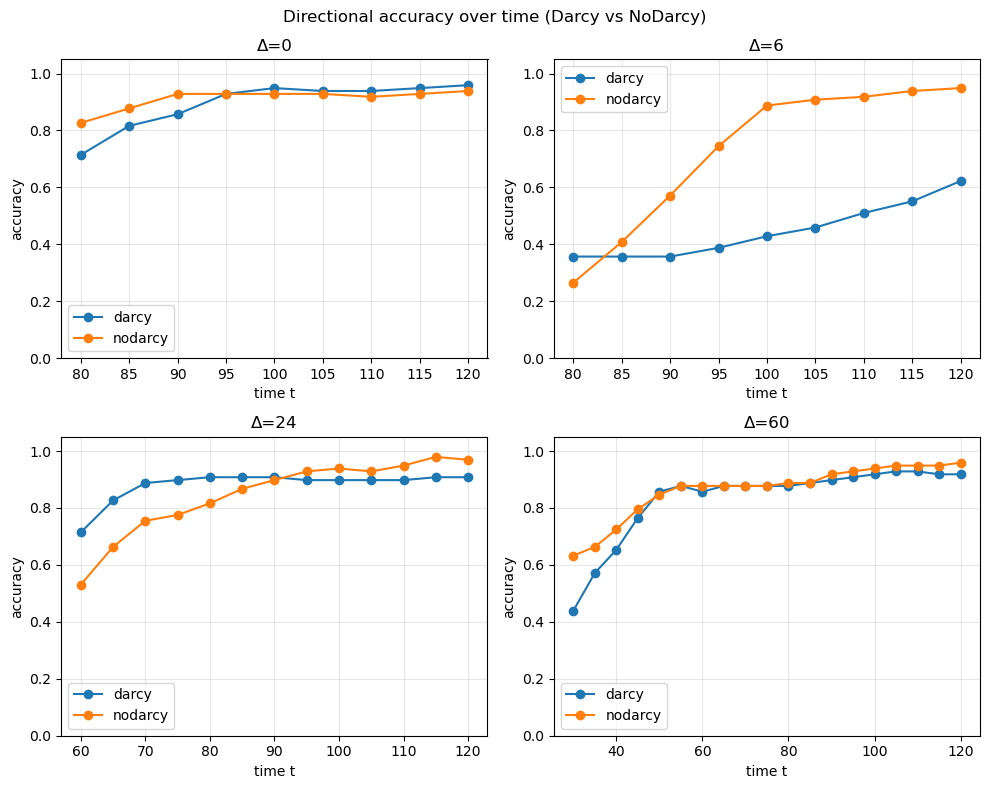

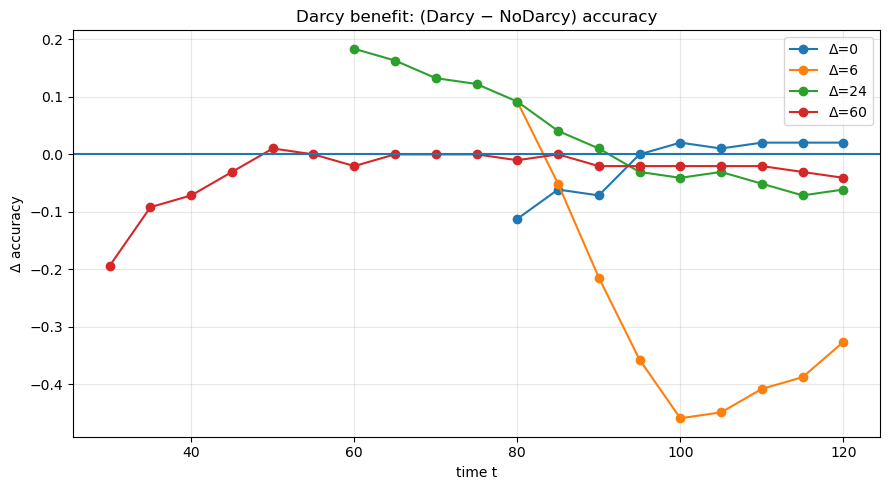

In [ ]:
deltas = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]   # pick 3–5
cfg = EvalConfig(
    score_mode="fixed",   # compares pred L/R vs fixed_labels
    handle_split="skip",  # skip splits for now (clean)
    channel=0,
    max_sims=250,
)
results = run_comparison(deltas, cfg)
plot_small_multiples(results)
plot_difference(results)

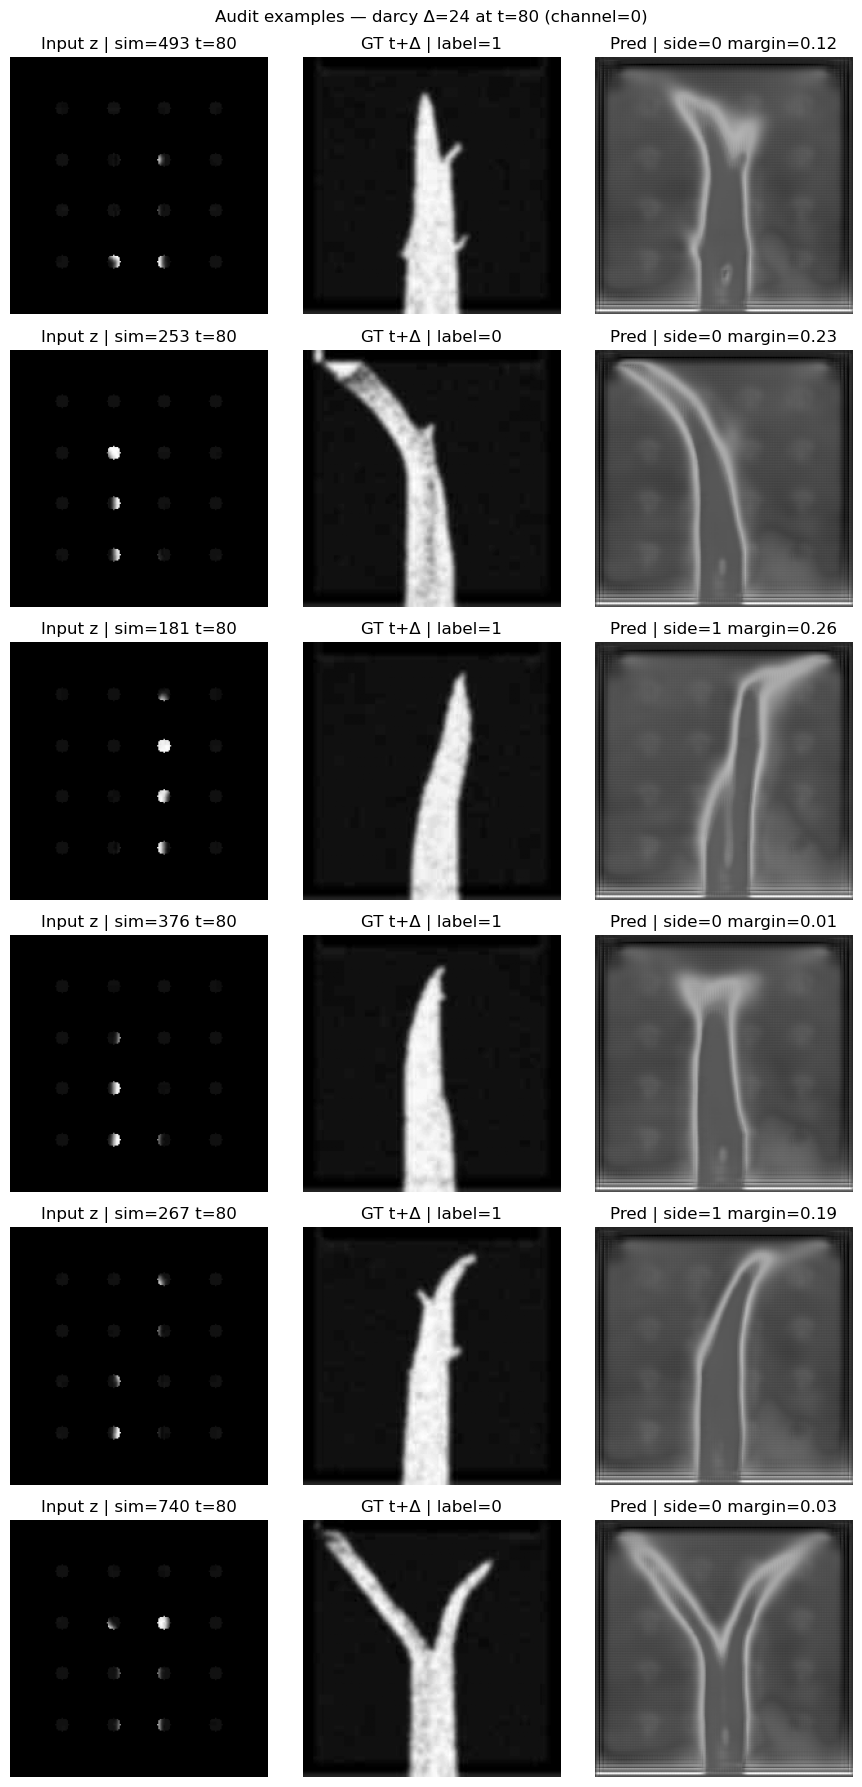

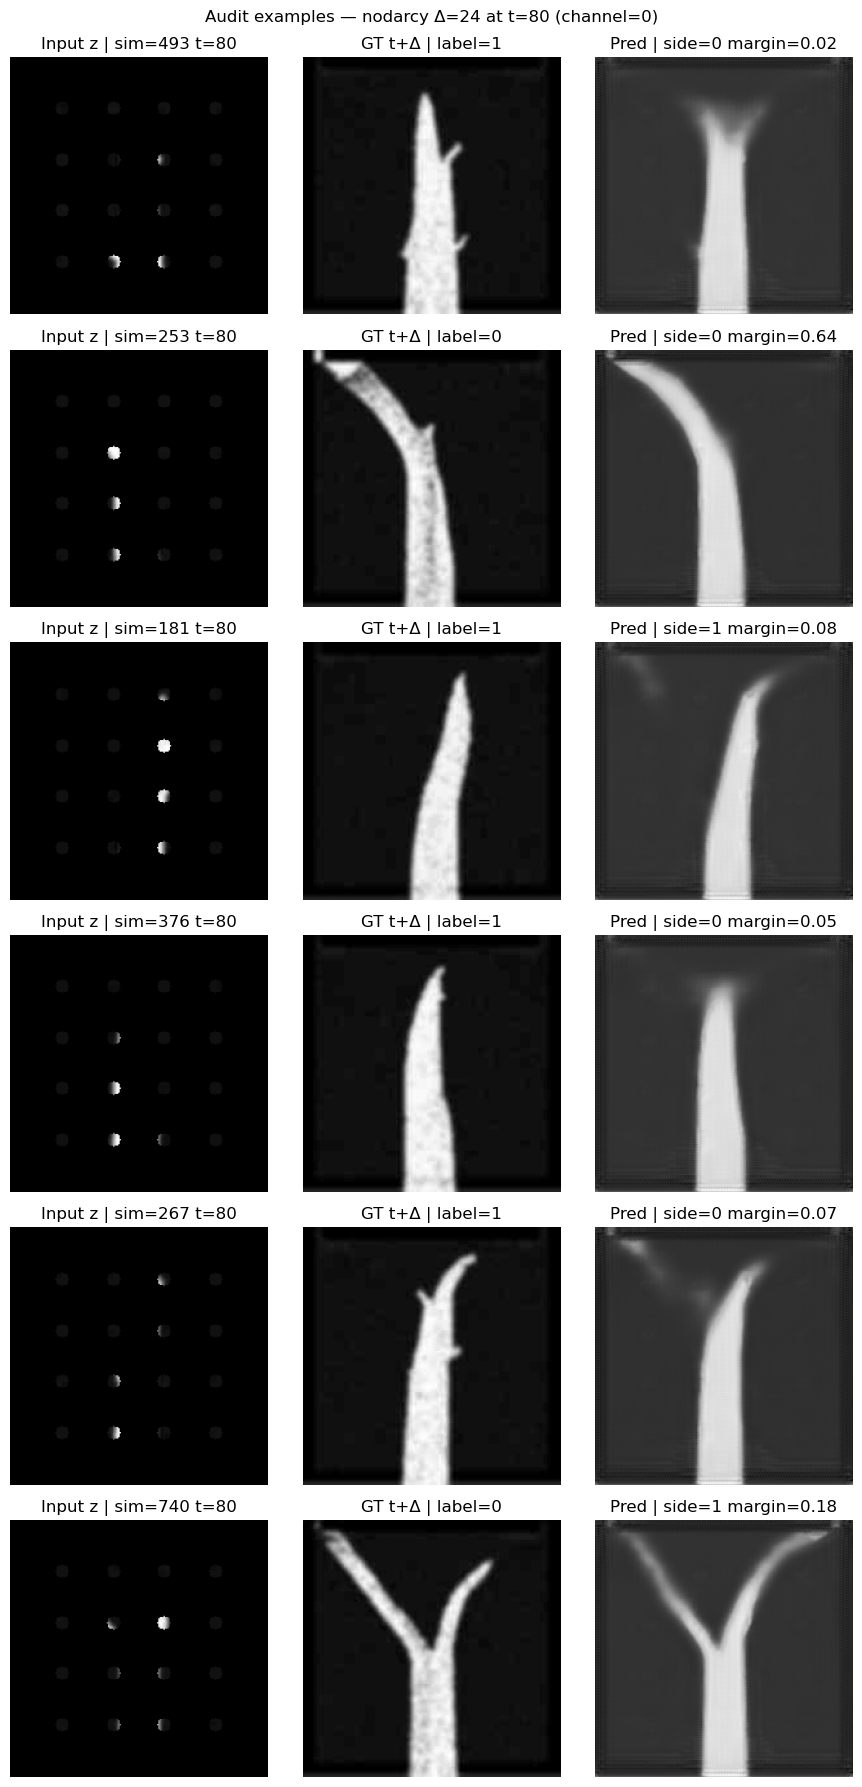

In [67]:
show_audit_examples(delta=24, cond="darcy",  n_examples=6, t=80, cfg=cfg)
show_audit_examples(delta=24, cond="nodarcy", n_examples=6, t=80, cfg=cfg)

In [ ]:
deltas = [12, 18, 30, 36, 42, 48, 54]   # pick 3–5
cfg = EvalConfig(
    score_mode="fixed",   # compares pred L/R vs fixed_labels
    handle_split="skip",  # skip splits for now (clean)
    channel=0,
    max_sims=250,
)
results = run_comparison(deltas, cfg)
plot_small_multiples(results)
plot_difference(results)

DARCY Δ=12: mean acc=0.427 over 1274 trials
NODARCY Δ=12: mean acc=0.770 over 1274 trials
DARCY Δ=18: mean acc=0.288 over 1274 trials
NODARCY Δ=18: mean acc=0.890 over 1274 trials
DARCY Δ=30: mean acc=0.381 over 1274 trials
NODARCY Δ=30: mean acc=0.920 over 1274 trials
DARCY Δ=36: mean acc=0.892 over 1274 trials
NODARCY Δ=36: mean acc=0.877 over 1274 trials
DARCY Δ=42: mean acc=0.785 over 1862 trials
NODARCY Δ=42: mean acc=0.807 over 1862 trials
DARCY Δ=48: mean acc=0.754 over 1862 trials
NODARCY Δ=48: mean acc=0.403 over 1862 trials
DARCY Δ=54: mean acc=0.853 over 1862 trials
